# Set up 

In [1]:
SEED = 1
import random
random.seed(SEED)

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm


import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/all_data/')

## Perturbing enzymes

In [3]:
Teusink_ant ='../../../models/Antimony/topologyA-noReg.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [4]:
pt_levels = [1.5]
pt_labels = ['1.5x']

In [5]:
metabolites = r.getFloatingSpeciesIds() + r.getBoundarySpeciesIds()
data = pd.read_csv('../../../data/generated_data/topologyA-noReg/topologyA-noReg_1.5.csv')

# Running ADVI

In [6]:
def run_BayesInf(BMCA_obj, n_samp=1):
    np.random.seed(SEED)
    random.seed(SEED)

    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in BMCA_obj.xn.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()

    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(r.getBoundarySpeciesIds()):
        if y in BMCA_obj.yn.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        if omitted_chi_inds: 
            chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
            chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))
            chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
            pm.Deterministic('chi_t', chi_t)
        else: 
            chi_t = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)

        if omitted_y_inds:
            y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.yn.T)
            y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=5, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))
            y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
            pm.Deterministic('y_t', y_t)
        else: 
            y_t = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace, random_seed=SEED)

    return trace, ppc_vi

No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 393.94
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 382.89
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 380.36
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 370.3
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 367.65
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 379.19
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 379.41
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 373.76
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 368.57
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 376.24
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 369.59
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 857.76
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 857.2
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 857.46
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


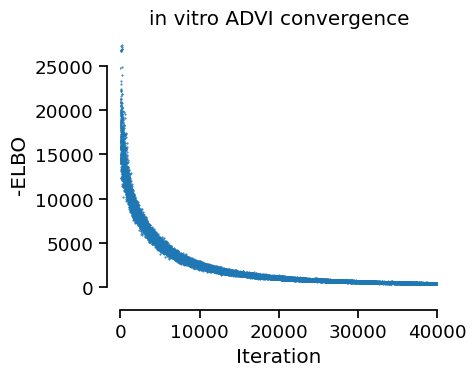

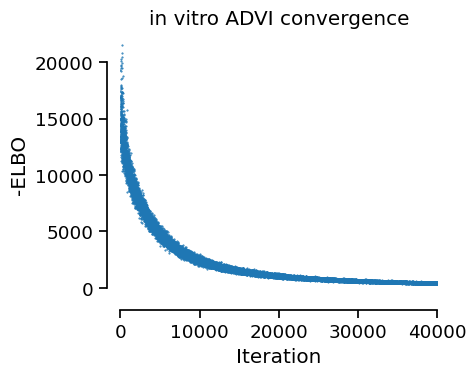

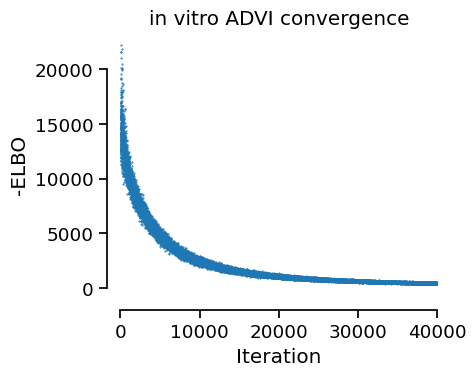

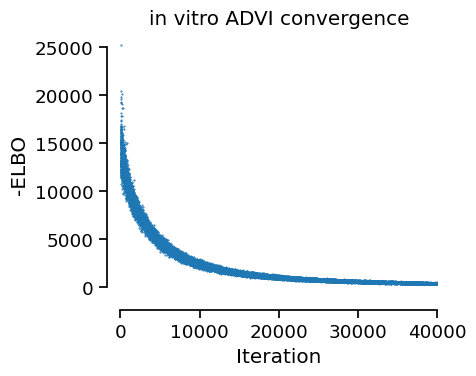

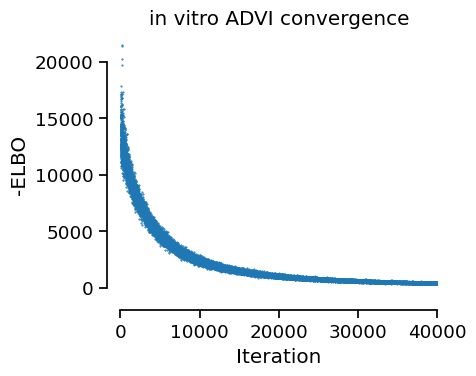

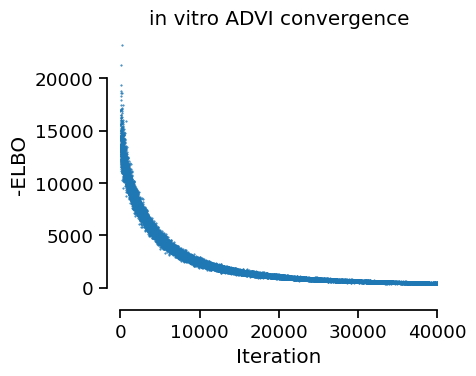

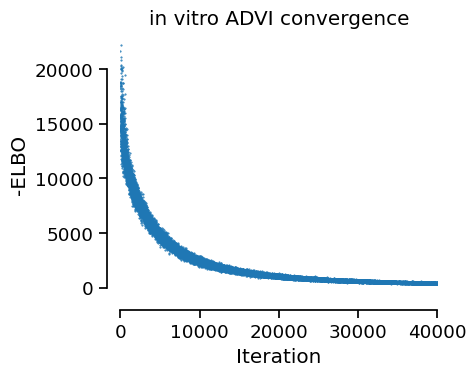

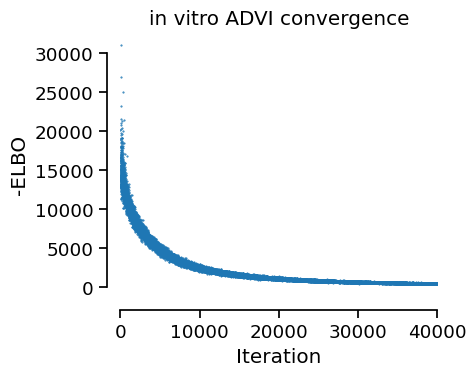

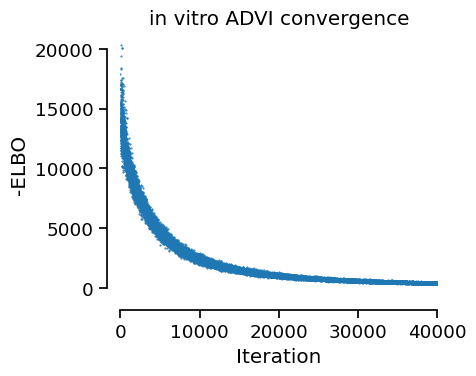

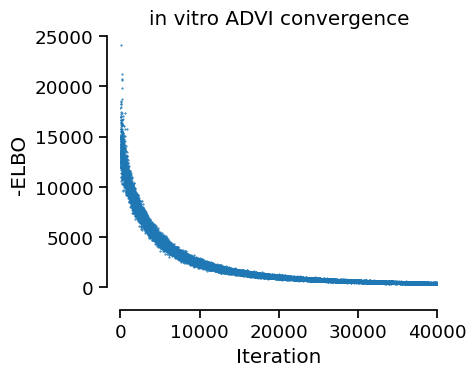

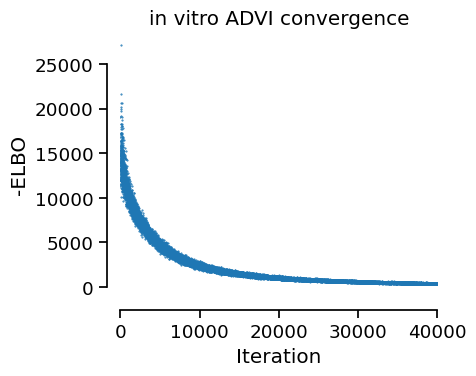

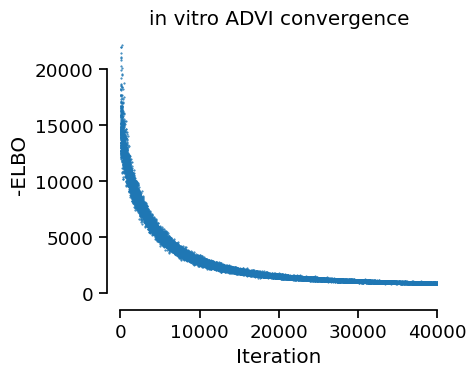

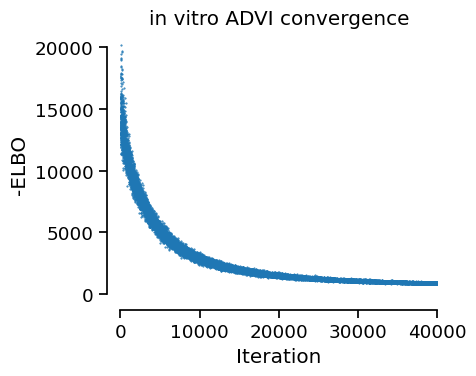

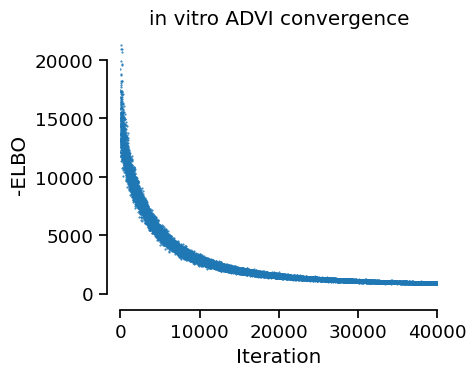

In [7]:
for m in metabolites: 
    data15 = data[data.columns.drop(m)]
    BMCA_obj15 = antemll.antemll(Teusink_ant, data15, '../../../models/sbml/topologyA_cobra.xml')
    trace15, ppc15 = run_BayesInf(BMCA_obj15)

    with gzip.open(f"../../../data/results/picklejar/giraffe-topA_{m}.pgz", "wb") as f:
            cloudpickle.dump(
                { 
                "trace15":trace15,
                "ppc15":ppc15,
                },
                f,
            )
# 

No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,018.7
Sampling: [chi_obs, e_t, v_hat_obs, y_obs]


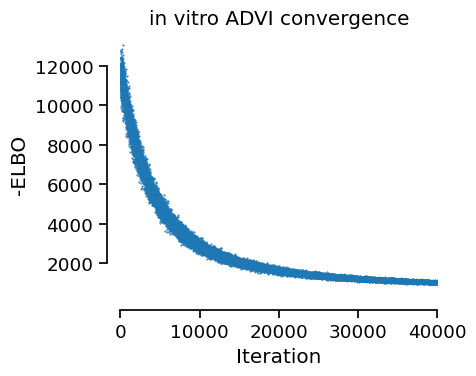

In [8]:
BMCA_obj15 = antemll.antemll(Teusink_ant, data, '../../../models/sbml/topologyA_cobra.xml')
trace15, ppc15 = run_BayesInf(BMCA_obj15)

with gzip.open(f"../../../data/results/picklejar/giraffe-topA_allMets.pgz", "wb") as f:
    cloudpickle.dump(
        { 
        "trace15":trace15,
        "ppc15":ppc15,
        },
        f,
    )

# Analysis

In [9]:
metSens_dict = dict()

for m in metabolites: 
    with gzip.open(f"../../../data/results/picklejar/giraffe-topA_{m}.pgz", "rb") as f:
        traces = cloudpickle.load(f, encoding='bytes')

    metSens_dict[m] = (traces['trace15'], traces['ppc15'])

with gzip.open(f"../../../data/results/picklejar/giraffe-topA_allMets.pgz", "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

metSens_dict['none'] = (traces['trace15'], traces['ppc15'])

### Elasticity check 

In [10]:
metSens_dict.keys()

dict_keys(['B__', 'E__', 'K__', 'G__', 'I__', 'Ai__', 'C__', 'F__', 'J__', 'D__', 'H__', 'Ao__', 'L__', 'Z__', 'none'])

In [11]:
Ex_dict = dict()

for i in metSens_dict.keys():
    Ex_dict[i] = util.get_az_summary(metSens_dict[i][0])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [12]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten()] + [Ex_dict[i] for i in Ex_dict.keys()])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+[i for i in Ex_dict.keys()], 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
elasticities_df.head()

,gt,B__,E__,K__,G__,I__,Ai__,C__,F__,J__,D__,H__,Ao__,L__,Z__,none
vKIL_B__,-1.437645,-0.184,-1.260,-1.260,-1.260,-1.260,-0.599,-1.259,-1.261,-1.261,-1.260,-1.260,-1.261,-1.260,-1.260,-1.250
vKIL_E__,0.000000,-0.006,-0.004,-0.004,-0.003,-0.004,-0.004,-0.005,-0.005,-0.005,-0.004,-0.004,-0.004,-0.004,-0.004,0.000
vKIL_K__,0.000000,-0.008,-0.005,-0.007,-0.005,-0.006,-0.005,-0.007,-0.007,-0.006,-0.006,-0.007,-0.005,-0.005,-0.006,0.004
vKIL_G__,0.000000,0.001,0.003,0.004,0.002,0.004,0.003,0.003,0.004,0.003,0.003,0.003,0.004,0.004,0.003,-0.008
vKIL_I__,0.000000,0.000,0.001,0.000,0.000,-0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002


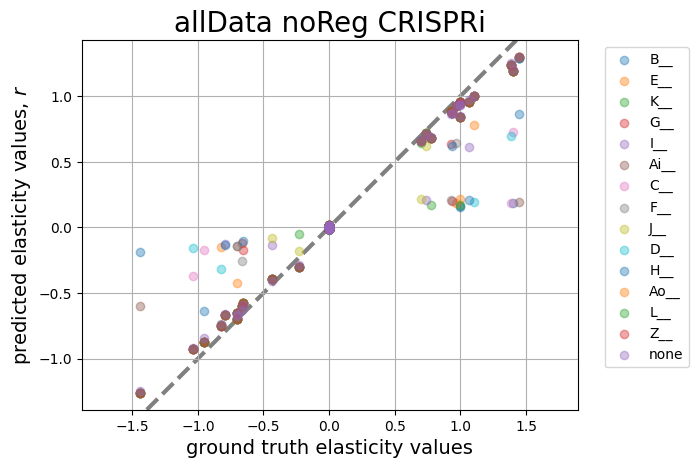

In [13]:
plt.axes().set_aspect('equal', 'datalim')

for i in Ex_dict.keys():
    plt.scatter(elasticities_df['gt'], elasticities_df[i], alpha=0.4, label=i, zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


In [14]:
RMSE = np.sqrt(((elasticities_df.sub(elasticities_df['gt'], axis=0))**2).mean())
RMSE

gt      0.000000
B__     0.169578
E__     0.109640
K__     0.086036
G__     0.089014
I__     0.084396
Ai__    0.126291
C__     0.133199
F__     0.087923
J__     0.059625
D__     0.120258
H__     0.101506
Ao__    0.038508
L__     0.038514
Z__     0.038468
none    0.038369
dtype: float64

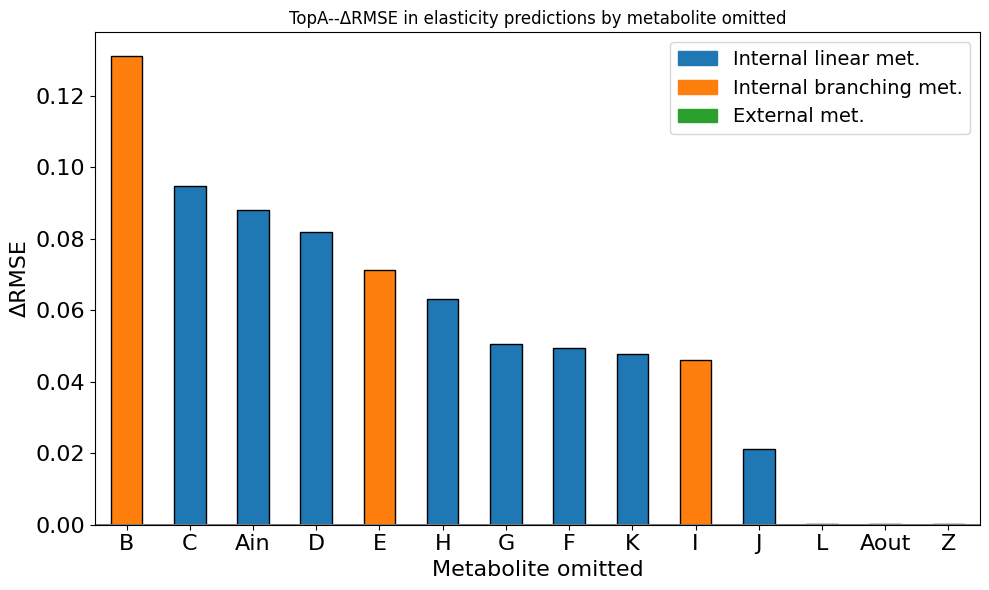

In [ ]:
highlight_labels = {'Ao__', 'L__', 'Z__'}
branch_labels = {'B__', 'E__', 'I__'}


RMSE_sorted = RMSE.drop(['gt','none'], errors='ignore')  # Drop gt if it's in there
RMSE_sorted = RMSE_sorted.sort_values(ascending=False)

delta_RMSE_sorted = RMSE_sorted.sub(RMSE['none'])
# Build a list of colors, yellow if in highlight_labels, skyblue otherwise
bar_colors = [
    'tab:green' if label in highlight_labels
    else 'tab:orange' if label in branch_labels
    else 'tab:blue'
    for label in delta_RMSE_sorted.index
]

plt.figure(figsize=(10, 6))

delta_RMSE_sorted.plot(kind='bar', edgecolor='black', color=bar_colors) # , color='skyblue')
# plt.ylim(1,1.14)
plt.ylabel("ΔRMSE", fontsize=16)
plt.xlabel("Metabolite omitted", fontsize=16)
plt.title("TopA--ΔRMSE in elasticity predictions by metabolite omitted")

sorted_ticks = [i.split('__')[0] for i in RMSE_sorted.index]
sorted_ticks = [
    'Ain' if label=='Ai'
    else 'Aout' if label=='Ao'
    else label
    for label in sorted_ticks
]

plt.xticks(ticks=range(len(RMSE_sorted)), labels=sorted_ticks, rotation=0, ha='center', fontsize=16)
plt.yticks(fontsize=16)

plt.axhline(0, color='gray')

plt.tight_layout()

# Create custom legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='tab:blue', label='Internal linear met.')
orange_patch = mpatches.Patch(color='tab:orange', label='Internal branching met.')
green_patch = mpatches.Patch(color='tab:green', label='External met.')
plt.legend(handles=[blue_patch, orange_patch, green_patch], fontsize=14)

plt.savefig('../../../visualize/raw_svg_figures/topologyA-giraffe.svg', format='svg')